<a href="https://colab.research.google.com/github/damladlg/FinalProject-BowelDisease-with-DeepLearning/blob/main/boweldisease_grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
  #drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imutils
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dropout, Dense

IMG_SIZE = 224

In [ ]:
train_dir = '/content/drive/MyDrive/extended-dataset/train'
test_dir = '/content/drive/MyDrive/extended-dataset/test'

classes = os.listdir(train_dir) 

os.mkdir('/content/Train-Data')
os.mkdir('/content/Test-Data')

for cls in classes:
  os.mkdir(f'/content/Train-Data/{cls}')
  os.mkdir(f'/content/Test-Data/{cls}')

In [ ]:
classes

['cancer', 'polyp', 'ulcerativecolits', 'normal', 'crohns']

In [ ]:
train_files_path = {cls: list(map(lambda x: os.path.join(train_dir, cls, x), os.listdir(os.path.join(train_dir, cls)))) for cls in classes}

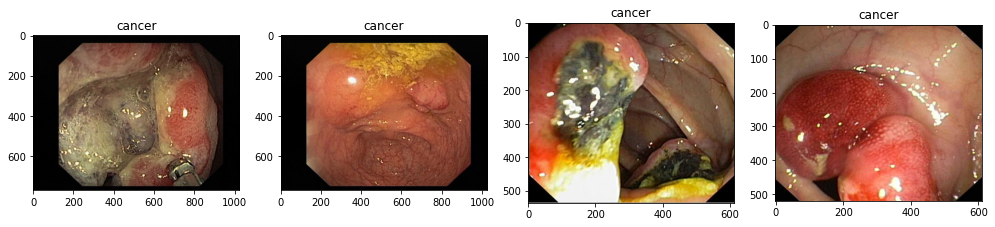

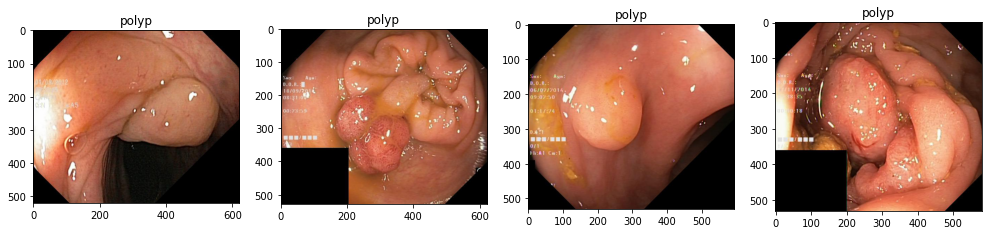

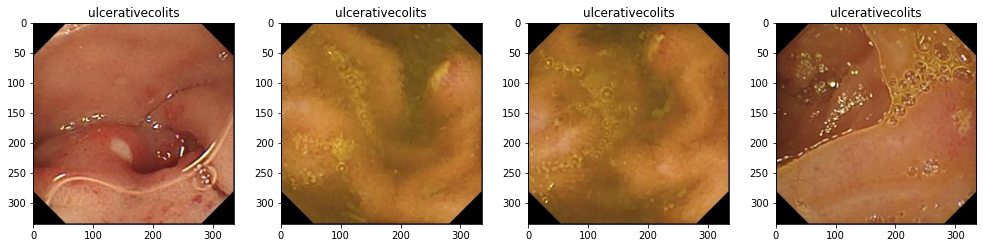

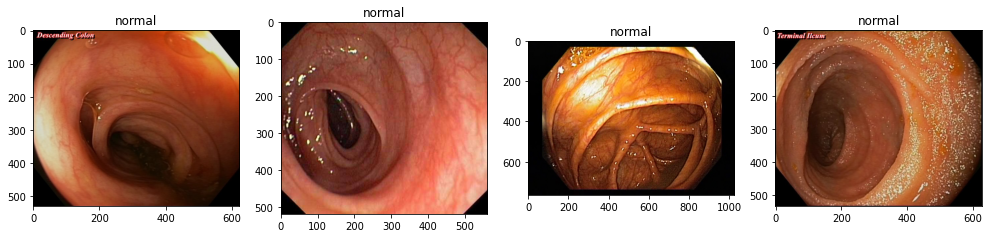

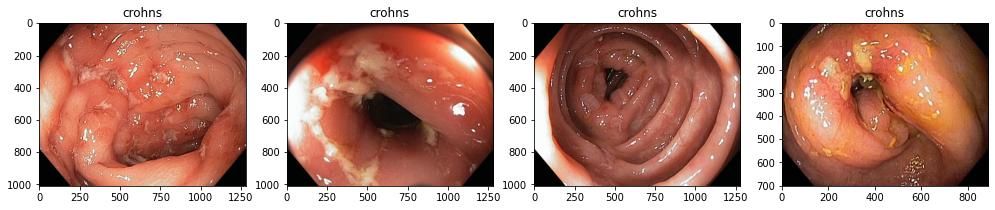

In [ ]:
for cls in classes:
  plt.figure(figsize=(17, 17))
  random.shuffle(train_files_path[cls])
  files = train_files_path[cls][:5]

  for i in range(1, 5):
    plt.subplot(4, 4, i)
    plt.imshow(load_img(files[i]))
    plt.title(cls)

In [ ]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [ ]:
train_class_paths = [os.path.join(train_dir, cls) for cls in classes]
test_class_paths = [os.path.join(test_dir, cls) for cls in classes]

In [ ]:
def crop_img_saver(class_read_paths, save_dir):
  save_root = '/content'

  for cls in class_read_paths:
    for i, p in tqdm(enumerate(os.listdir(cls))):
      path = os.path.join(cls, p)
      img = crop_image(cv2.imread(path), plot=False)

      if img is not None:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        save_class = cls.split('/')[-1]
        save_path = os.path.join(save_root, save_dir, save_class, f'{str(i)}.jpg')
        cv2.imwrite(save_path, img)

In [ ]:
crop_img_saver(train_class_paths, save_dir='Train-Data')

crop_img_saver(test_class_paths, save_dir='Test-Data')

258it [00:05, 47.69it/s]
950it [00:21, 44.26it/s] 
926it [00:24, 38.12it/s]
36it [00:09,  3.69it/s]
107it [00:03, 29.40it/s]
28it [00:07,  3.52it/s]
105it [00:02, 50.70it/s]
100it [00:02, 40.49it/s]
5it [00:01,  3.50it/s]
11it [00:03,  3.09it/s]


In [ ]:
#Augmentation
train_data_generator = ImageDataGenerator(rotation_range=10, 
                                          height_shift_range=0.2, 
                                          horizontal_flip=True, 
                                          validation_split=0.2)

train_data = train_data_generator.flow_from_directory('/content/Train-Data/',
                                                      target_size=(IMG_SIZE, IMG_SIZE),
                                                      batch_size=8,
                                                      class_mode='categorical',
                                                      subset='training')

validation_data = train_data_generator.flow_from_directory('/content/Train-Data',
                                                           target_size=(IMG_SIZE, IMG_SIZE),
                                                           batch_size=8,
                                                           class_mode='categorical',
                                                           subset='validation')

test_data_generator = ImageDataGenerator()

test_data = test_data_generator.flow_from_directory('/content/Test-Data/',
                                        target_size=(IMG_SIZE, IMG_SIZE),
                                        shuffle=False,
                                        class_mode='categorical')

Found 1823 images belonging to 5 classes.
Found 454 images belonging to 5 classes.
Found 249 images belonging to 5 classes.


In [ ]:
print(train_data.class_indices, test_data.class_indices, sep='\n')

{'cancer': 0, 'crohns': 1, 'normal': 2, 'polyp': 3, 'ulcerativecolits': 4}
{'cancer': 0, 'crohns': 1, 'normal': 2, 'polyp': 3, 'ulcerativecolits': 4}


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


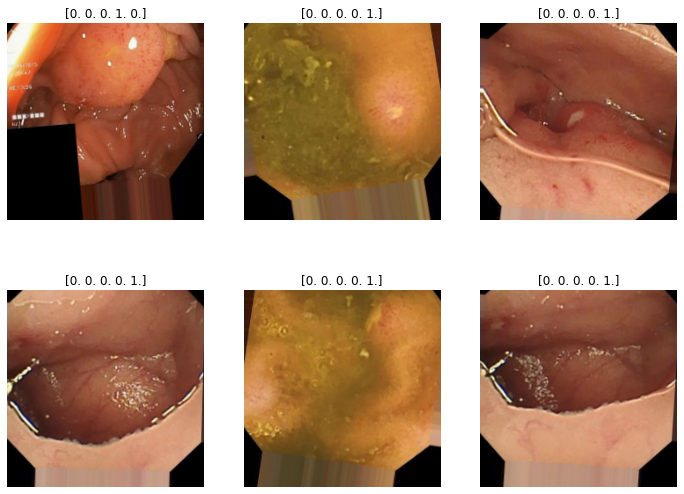

In [ ]:
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.axis('off'), plt.grid(False)
  # sample_img = array_to_img(sample_x[i])
  plt.imshow(array_to_img(sample_x[i]))
  plt.title(sample_y[i])

In [ ]:
import keras
from tensorflow.keras.applications import EfficientNetB6

effnet = EfficientNetB6(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(5, activation='softmax')(model)
model = Model(inputs=effnet.input, outputs=model)

model.summary()

165249024/165234480 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=5,
                                                  mode='auto',
                                                  verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint('model_ckpt.h5', 
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                mode='auto',
                                                verbose=1)

In [ ]:
epoch = 50
history = model.fit(train_data, 
                    epochs=epoch, 
                    validation_data=validation_data, 
                    callbacks=[checkpoint],
                    use_multiprocessing=True,
                    verbose=1)

Epoch 1/50
228/228 [==============================] - ETA: 0s - loss: 0.0448 - accuracy: 0.9841
Epoch 1: val_accuracy improved from 0.95374 to 0.95595, saving model to model_ckpt.h5
228/228 [==============================] - 275s 1s/step - loss: 0.0448 - accuracy: 0.9841 - val_loss: 0.2196 - val_accuracy: 0.9559
Epoch 2/50
228/228 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9890
Epoch 2: val_accuracy improved from 0.95595 to 0.95815, saving model to model_ckpt.h5
228/228 [==============================] - 269s 1s/step - loss: 0.0348 - accuracy: 0.9890 - val_loss: 0.1761 - val_accuracy: 0.9581
Epoch 3/50
228/228 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9896
Epoch 3: val_accuracy did not improve from 0.95815
228/228 [==============================] - 271s 1s/step - loss: 0.0273 - accuracy: 0.9896 - val_loss: 0.2267 - val_accuracy: 0.9427
Epoch 4/50
228/228 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.98

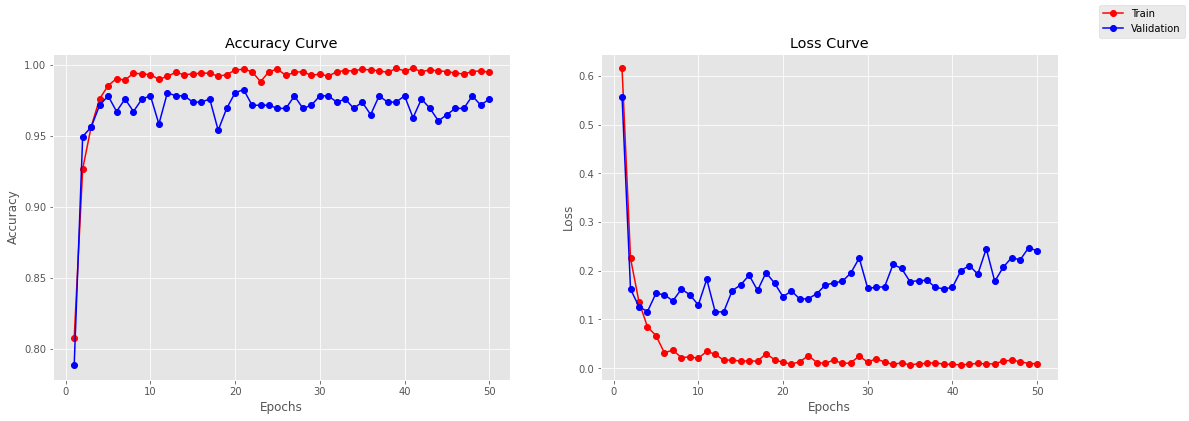

In [ ]:
plt.style.use('ggplot')
figure = plt.figure(figsize=(18, 6))
epochs = range(1, epoch + 1)

plt.subplot(121)
plt.plot(epochs, history.history['accuracy'], 'ro-')
plt.plot(epochs, history.history['val_accuracy'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy Curve')

plt.subplot(122)
plt.plot(epochs, history.history['loss'], 'ro-')
plt.plot(epochs, history.history['val_loss'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss Curve')

figure.legend(['Train', 'Validation'])

In [ ]:
acc = model.evaluate(test_data)
acc

8/8 [==============================] - 6s 592ms/step - loss: 0.4097 - accuracy: 0.9438


[0.40966999530792236, 0.9437751173973083]

In [ ]:
from numpy import loadtxt
from keras.models import load_model
 
# load model
my_model = load_model('model_ckpt.h5')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_data.reset()
y_pred = model.predict(test_data, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
print('\nConfusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')
target_names = ['Cancer', 'Crohns', 'Normal', 'Polyp', 'UlcerativeColits']
print(classification_report(test_data.classes, y_pred, target_names=target_names))

8/8 [==============================] - 6s 409ms/step

Confusion Matrix
[[ 22   1   0   2   3]
 [  1  10   0   0   0]
 [  0   0   4   1   0]
 [  0   0   0 105   0]
 [  4   0   1   1  94]]
Classification Report
                  precision    recall  f1-score   support

          Cancer       0.81      0.79      0.80        28
          Crohns       0.91      0.91      0.91        11
          Normal       0.80      0.80      0.80         5
           Polyp       0.96      1.00      0.98       105
UlcerativeColits       0.97      0.94      0.95       100

        accuracy                           0.94       249
       macro avg       0.89      0.89      0.89       249
    weighted avg       0.94      0.94      0.94       249

